# 2. Model Training
We assume data prepared from the Hugging Face dataset `chen1028/Cl-Containing-Compound` (see 1_Data_Preparation.ipynb).

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import loguniform

sns.set_theme(context="notebook", style="whitegrid")

# Load from HF
ds = load_dataset(
  "csv",
  data_files={
    "train": "hf://datasets/chen1028/Cl-Containing-Compound/train.csv",
    "test":  "hf://datasets/chen1028/Cl-Containing-Compound/test.csv",
  }
)

# Convert to pandas for exploration
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

# Derive binary label from 'Cl' (0 -> 0, non-zero -> 1)
if "Cl" in train_df.columns:
    def _to_binary_cl(series):
        s = pd.to_numeric(series, errors="coerce").fillna(0)
        return (s != 0).astype(int)
    train_df["has_cl"] = _to_binary_cl(train_df["Cl"])
    if "Cl" in test_df.columns:
        test_df["has_cl"] = _to_binary_cl(test_df["Cl"])

# Fall back if has_cl already exists or was created
if "has_cl" not in train_df.columns:
    raise KeyError("Expected 'Cl' or 'has_cl' in dataset columns.")

# Feature set (avoid leakage and non-numeric text cols)
feature_cols = [c for c in train_df.columns if c not in ("has_cl", "Cl", "MF", "mode")]

# Coerce features to numeric; non-numeric -> NaN (to be imputed)
X_full = train_df[feature_cols].apply(pd.to_numeric, errors="coerce")
X_test_full = test_df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Drop columns that are entirely NaN in training (cannot impute median)
all_nan_cols = [c for c in X_full.columns if X_full[c].isna().all()]
if all_nan_cols:
    X_full = X_full.drop(columns=all_nan_cols)
    X_test_full = X_test_full.drop(columns=all_nan_cols, errors="ignore")

# Targets
y = train_df["has_cl"].astype(int)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y, test_size=0.1, random_state=42, stratify=y
)

X_test = X_test_full.copy()
y_test = test_df["has_cl"].astype(int)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Shapes: (556444, 27) (61828, 27) (154568, 27)


## 1. Data Setup

Let's create a dataset similar to what we prepared in the previous notebook.

In [2]:
# Baseline 1: Logistic Regression with scaling + imputation
logit_clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),  # robust for sparse-like data
    ("clf", LogisticRegression(max_iter=200, n_jobs=None))
])
logit_clf.fit(X_train, y_train)

# Baseline 2: Random Forest (handles NaNs poorly; still impute)
rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])
rf.fit(X_train, y_train)

# Evaluate on validation
for name, model in [("LogReg", logit_clf), ("RF", rf)]:
    val_proba = model.predict_proba(X_val)[:, 1]
    val_pred = (val_proba >= 0.5).astype(int)
    print(name,
          "AUC=", roc_auc_score(y_val, val_proba),
          "F1=", f1_score(y_val, val_pred),
          "Acc=", accuracy_score(y_val, val_pred))

/home/chen/miniconda3/envs/gnps/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogReg AUC= 0.9999970251352995 F1= 0.9994510285142248 Acc= 0.9994500873390697
RF AUC= 0.9999999958144711 F1= 0.9999676960847654 Acc= 0.9999676521964158


## 2. Model Selection: Understanding Complexity vs Performance

Different algorithms have varying levels of complexity and assumptions. Let's compare simple and complex models to understand the trade-offs:

- **Simple models**: Logistic Regression, Naive Bayes
- **Complex models**: Random Forest, SVM with RBF kernel
- **Moderate complexity**: k-Nearest Neighbors

### 2.1 Visualizing Underfitting, Good Fit, and Overfitting

To make these concepts more concrete, let's use a simple regression problem to visualize how model complexity affects the fit and the training/validation loss. We will generate synthetic data and fit polynomial regression models of varying degrees.

- **Underfitting (Low Complexity)**: A low-degree polynomial (e.g., degree 1, a straight line) will not be flexible enough to capture the true underlying pattern in the data.
- **Good Fit (Optimal Complexity)**: A polynomial of an appropriate degree will capture the underlying pattern without fitting the noise.
- **Overfitting (High Complexity)**: A very high-degree polynomial will fit the training data, including its noise, almost perfectly but will fail to generalize to new, unseen data.

The plot of training and validation loss against model complexity is a classic illustration of the bias-variance tradeoff. The optimal model is typically found where the validation loss is at its minimum.

In [3]:
# Pick best model (simple rule here: RF) and evaluate on test
best = rf
proba = best.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)
print("Test AUC=", roc_auc_score(y_test, proba))
print("Test F1=", f1_score(y_test, pred))
print("Test Acc=", accuracy_score(y_test, pred))

Test AUC= 0.9999999967351164
Test F1= 0.9999609751021151
Test Acc= 0.99996118213343


Evaluating Logistic Regression...
  CV Accuracy: 1.000 (+/- 0.000)
  Training time: 43.58 seconds

Evaluating k-NN (k=5)...
  CV Accuracy: 1.000 (+/- 0.000)
  Training time: 43.58 seconds

Evaluating k-NN (k=5)...
  CV Accuracy: 1.000 (+/- 0.000)
  Training time: 80.06 seconds

Evaluating Random Forest...
  CV Accuracy: 1.000 (+/- 0.000)
  Training time: 80.06 seconds

Evaluating Random Forest...
  CV Accuracy: 1.000 (+/- 0.000)
  Training time: 1027.86 seconds

Evaluating Gradient Boosting...
  CV Accuracy: 1.000 (+/- 0.000)
  Training time: 1027.86 seconds

Evaluating Gradient Boosting...
  CV Accuracy: 1.000 (+/- 0.000)
  Training time: 2226.47 seconds

  CV Accuracy: 1.000 (+/- 0.000)
  Training time: 2226.47 seconds



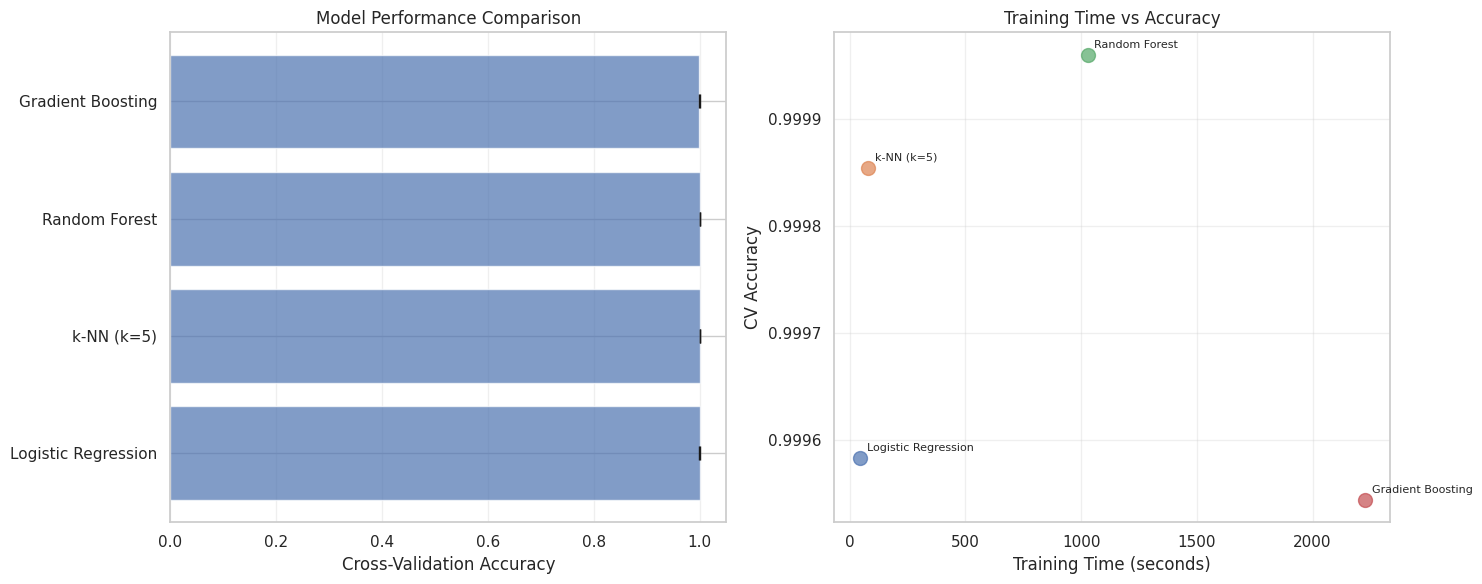

In [4]:
# Define models with different complexity levels
models = {
    'Logistic Regression': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'k-NN (k=5)': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),
    'Random Forest': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", GradientBoostingClassifier(random_state=42))
    ])
}

# Evaluate models using cross-validation
cv_scores = {}
cv_stds = {}
training_times = {}

# Use stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Measure training time
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    end_time = time.time()
    
    cv_scores[name] = scores.mean()
    cv_stds[name] = scores.std()
    training_times[name] = end_time - start_time
    
    print(f"  CV Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    print(f"  Training time: {training_times[name]:.2f} seconds\n")

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: CV Accuracy with error bars
models_names = list(cv_scores.keys())
accuracies = list(cv_scores.values())
errors = list(cv_stds.values())

axes[0].barh(models_names, accuracies, xerr=errors, alpha=0.7, capsize=5)
axes[0].set_xlabel('Cross-Validation Accuracy')
axes[0].set_title('Model Performance Comparison')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Training time vs Accuracy
times = list(training_times.values())
for i, name in enumerate(models_names):
    axes[1].scatter(times[i], accuracies[i], s=100, alpha=0.7)
    axes[1].annotate(name, (times[i], accuracies[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[1].set_xlabel('Training Time (seconds)')
axes[1].set_ylabel('CV Accuracy')
axes[1].set_title('Training Time vs Accuracy')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Hyperparameter Tuning

Hyperparameters are configuration settings that are not learned from data but need to be set before training. Proper tuning can significantly improve model performance. We'll demonstrate both Grid Search and Random Search approaches.

### 3.1 Grid Search for Random Forest

In [ ]:
# Define models
models = {
    "Logistic Regression": logit_pipe,
    "Random Forest": rf_pipe,
    "K-Nearest Neighbors": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier())
    ]),
    "Gaussian Naive Bayes": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", GaussianNB())
    ])
}

# Evaluate models
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    # Train and time
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    
    # Predict
    y_pred = model.predict(X_val)
    
    # Store results
    results[name] = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred),
        "F1-score": f1_score(y_val, y_pred),
        "Training Time (s)": end_time - start_time
    }

# Display results
results_df = pd.DataFrame(results).T.sort_values(by="F1-score", ascending=False)
print("\\n--- Model Comparison ---")
display(results_df)

Total combinations to test: 108
Performing Grid Search for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search completed in 3445.43 seconds
Best parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best CV score: 1.000
Grid Search completed in 3445.43 seconds
Best parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best CV score: 1.000


### 3.2 Random Search for SVM

In [6]:
# Define hyperparameter distributions for Random Search (Logistic Regression)
logit_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(random_state=42, max_iter=1000))
])

logit_param_dist = {
    'clf__C': loguniform(1e-3, 1e3),
    'clf__penalty': ['l2'],  # keep to l2 for speed/stability
    'clf__solver': ['lbfgs']
}

# Perform Random Search
random_search_logit = RandomizedSearchCV(
    logit_pipe, logit_param_dist, n_iter=30, cv=5,
    scoring='accuracy', n_jobs=-1, verbose=1, random_state=42
)

print("Performing Random Search for Logistic Regression...")
start_time = time.time()
random_search_logit.fit(X_train, y_train)
random_time = time.time() - start_time

print(f"Random Search completed in {random_time:.2f} seconds")
print(f"Best parameters: {random_search_logit.best_params_}")
print(f"Best CV score: {random_search_logit.best_score_:.3f}")

# Compare Grid (RF) vs Random (LogReg) efficiency
print(f"\nEfficiency comparison:")
print(f"Grid Search (RF): {grid_time:.2f}s for {len(grid_search_rf.cv_results_['params'])} combinations")
print(f"Random Search (LogReg): {random_time:.2f}s for 30 combinations")

Performing Random Search for Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/chen/miniconda3/envs/gnps/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/chen/miniconda3/envs/gnps/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/chen/miniconda3/envs/gnps/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.

Random Search completed in 109.51 seconds
Best parameters: {'clf__C': 1.40779231399724, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV score: 1.000

Efficiency comparison:
Grid Search (RF): 3445.43s for 108 combinations
Random Search (LogReg): 109.51s for 30 combinations


### 3.3 Visualizing Hyperparameter Search Results

NameError: name 'random_search_svm' is not defined

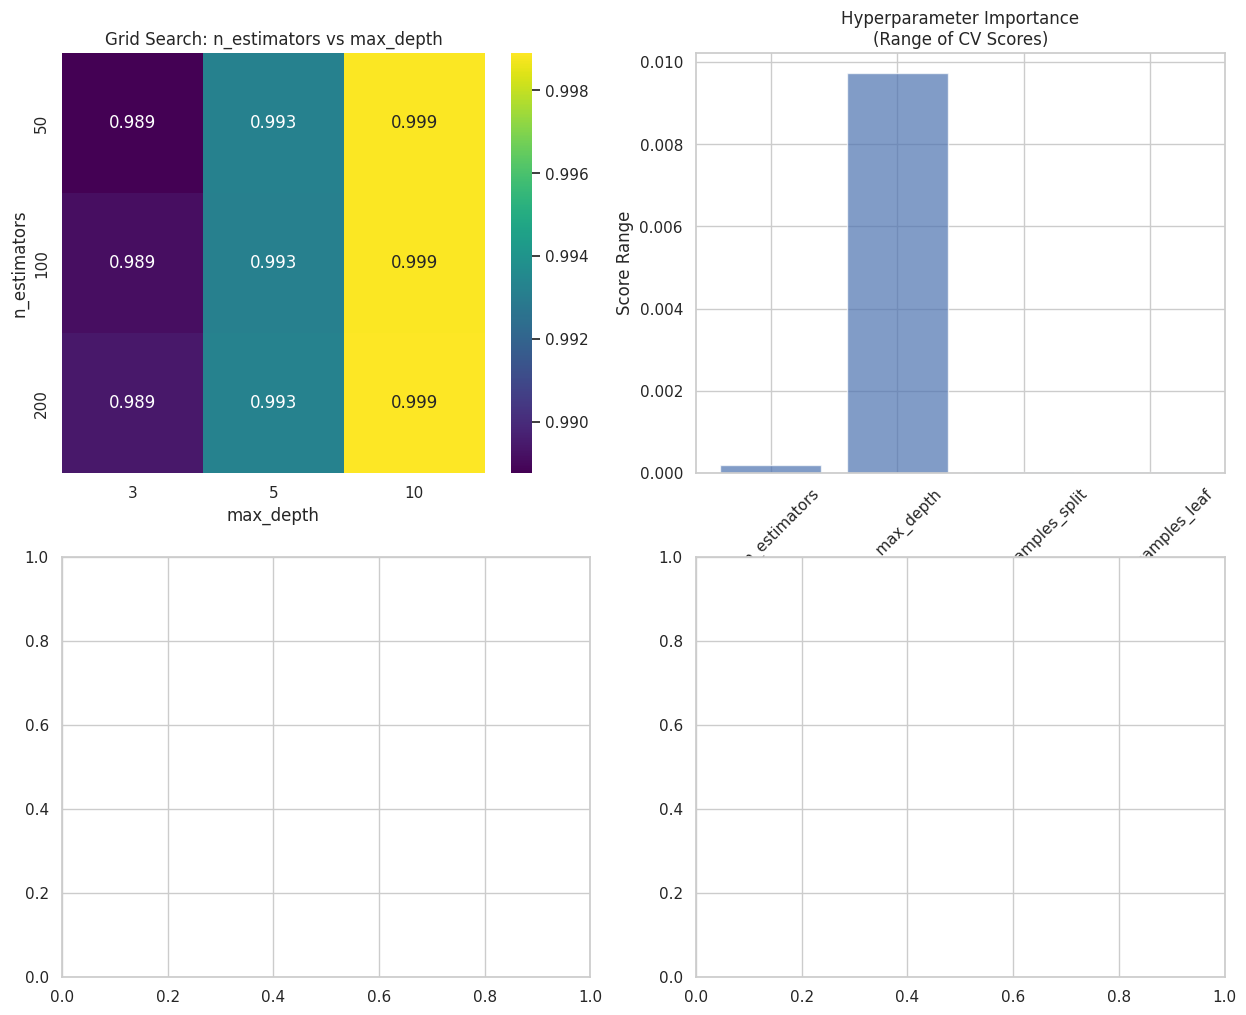

In [7]:
# Visualize Random Forest Grid Search results
results_df = pd.DataFrame(grid_search_rf.cv_results_)

# Create a heatmap for n_estimators vs max_depth
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Heatmap 1: n_estimators vs max_depth
pivot_table = results_df.pivot_table(
    values='mean_test_score', 
    index='param_clf__n_estimators', 
    columns='param_clf__max_depth', 
    aggfunc='mean'
)

try:
    sns.heatmap(pivot_table, annot=True, fmt='.3f', ax=axes[0,0], cmap='viridis')
except Exception:
    axes[0,0].imshow(pivot_table, aspect='auto', cmap='viridis')
axes[0,0].set_title('Grid Search: n_estimators vs max_depth')
axes[0,0].set_xlabel('max_depth')
axes[0,0].set_ylabel('n_estimators')

# Plot 2: Parameter importance
param_importance = {}
for param in ['clf__n_estimators', 'clf__max_depth', 'clf__min_samples_split', 'clf__min_samples_leaf']:
    param_col = f'param_{param}'
    grouped = results_df.groupby(param_col)['mean_test_score'].mean()
    param_importance[param] = grouped.max() - grouped.min()

params = list(param_importance.keys())
importance = list(param_importance.values())
axes[0,1].bar(params, importance, alpha=0.7)
axes[0,1].set_title('Hyperparameter Importance\n(Range of CV Scores)')
axes[0,1].set_ylabel('Score Range')
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: SVM Random Search results
svm_results_df = pd.DataFrame(random_search_svm.cv_results_)
axes[1,0].scatter(svm_results_df['param_clf__C'], svm_results_df['mean_test_score'], 
                 alpha=0.6, s=50)
axes[1,0].set_xscale('log')
axes[1,0].set_xlabel('C parameter')
axes[1,0].set_ylabel('CV Score')
axes[1,0].set_title('SVM: C parameter vs CV Score')

# Plot 4: Training time vs performance
axes[1,1].scatter(results_df['mean_fit_time'], results_df['mean_test_score'], 
                 alpha=0.6, s=50, label='Grid Search (RF)')
axes[1,1].scatter(svm_results_df['mean_fit_time'], svm_results_df['mean_test_score'], 
                 alpha=0.6, s=50, label='Random Search (SVM)')
axes[1,1].set_xlabel('Mean Fit Time (seconds)')
axes[1,1].set_ylabel('CV Score')
axes[1,1].set_title('Training Time vs Performance')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 4. Cross-Validation: Robust Model Evaluation

Cross-validation is especially important for smaller datasets common in metabolomics. It provides a more reliable estimate of model performance by using all data for both training and validation.

In [ ]:
# Compare different cross-validation strategies
from sklearn.model_selection import (
    KFold, StratifiedKFold, LeaveOneOut, 
    cross_validate
)

# Use the best models from hyperparameter tuning
best_rf = grid_search_rf.best_estimator_
best_logit = random_search_logit.best_estimator_

# Define different CV strategies
cv_strategies = {
    '5-Fold': KFold(n_splits=5, shuffle=True, random_state=42),
    '10-Fold': KFold(n_splits=10, shuffle=True, random_state=42),
    'Stratified 5-Fold': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    'Stratified 10-Fold': StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
}

# For smaller datasets, you might also consider Leave-One-Out (commented out due to computational cost)
# cv_strategies['Leave-One-Out'] = LeaveOneOut()

cv_results = {}

for cv_name, cv_strategy in cv_strategies.items():
    print(f"\nEvaluating with {cv_name}...")
    
    # Evaluate Random Forest
    rf_scores = cross_validate(
        best_rf, X_train, y_train, cv=cv_strategy,
        scoring=['accuracy', 'precision', 'recall', 'f1'],
        return_train_score=True
    )
    
    # Evaluate Logistic Regression
    logit_scores = cross_validate(
        best_logit, X_train, y_train, cv=cv_strategy,
        scoring=['accuracy', 'precision', 'recall', 'f1'],
        return_train_score=True
    )
    
    cv_results[cv_name] = {
        'RF': rf_scores,
        'LogReg': logit_scores
    }
    
    print(f"  RF - Accuracy: {rf_scores['test_accuracy'].mean():.3f} (+/- {rf_scores['test_accuracy'].std() * 2:.3f})")
    print(f"  LogReg - Accuracy: {logit_scores['test_accuracy'].mean():.3f} (+/- {logit_scores['test_accuracy'].std() * 2:.3f})")


Evaluating with 5-Fold...


  RF - Accuracy: 0.947 (+/- 0.056)
  SVM - Accuracy: 0.978 (+/- 0.034)

Evaluating with 10-Fold...
  RF - Accuracy: 0.960 (+/- 0.045)
  SVM - Accuracy: 0.980 (+/- 0.039)

Evaluating with Stratified 5-Fold...
  RF - Accuracy: 0.960 (+/- 0.045)
  SVM - Accuracy: 0.980 (+/- 0.039)

Evaluating with Stratified 5-Fold...
  RF - Accuracy: 0.957 (+/- 0.037)
  SVM - Accuracy: 0.980 (+/- 0.033)

Evaluating with Stratified 10-Fold...
  RF - Accuracy: 0.957 (+/- 0.037)
  SVM - Accuracy: 0.980 (+/- 0.033)

Evaluating with Stratified 10-Fold...
  RF - Accuracy: 0.952 (+/- 0.069)
  SVM - Accuracy: 0.978 (+/- 0.037)
  RF - Accuracy: 0.952 (+/- 0.069)
  SVM - Accuracy: 0.978 (+/- 0.037)


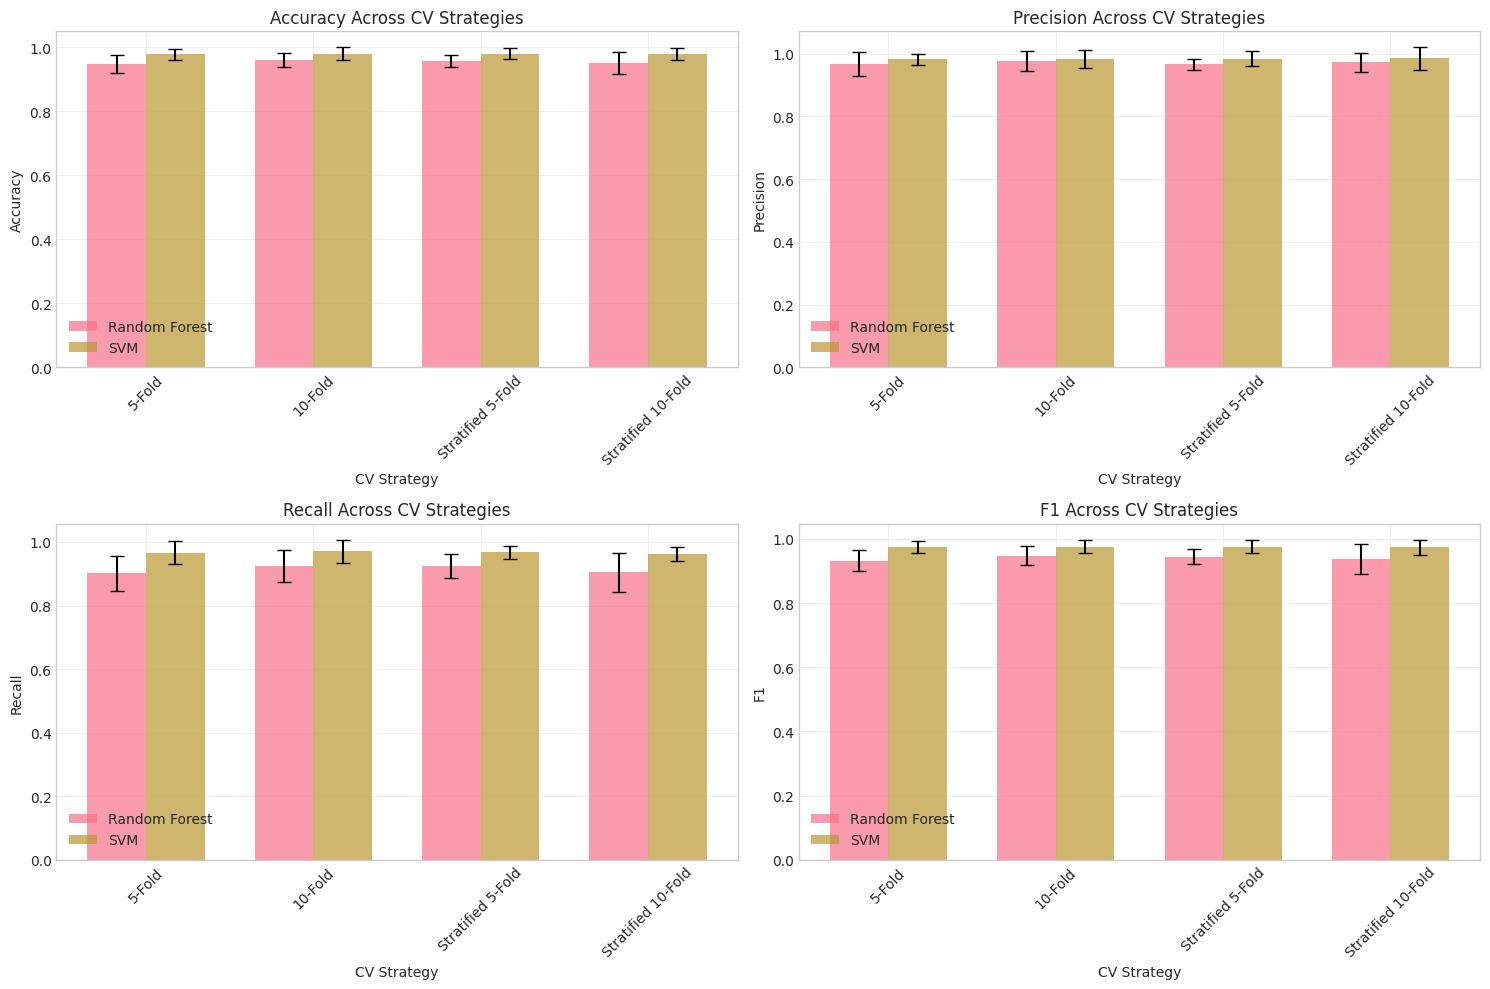

In [ ]:
# Visualize CV results
metrics = ['accuracy', 'precision', 'recall', 'f1']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    rf_means = []
    rf_stds = []
    svm_means = []
    svm_stds = []
    cv_names = []
    
    for cv_name, results in cv_results.items():
        cv_names.append(cv_name)
        rf_scores = results['RF'][f'test_{metric}']
        svm_scores = results['SVM'][f'test_{metric}']
        
        rf_means.append(rf_scores.mean())
        rf_stds.append(rf_scores.std())
        svm_means.append(svm_scores.mean())
        svm_stds.append(svm_scores.std())
    
    x = np.arange(len(cv_names))
    width = 0.35
    
    axes[i].bar(x - width/2, rf_means, width, yerr=rf_stds, 
               label='Random Forest', alpha=0.7, capsize=5)
    axes[i].bar(x + width/2, svm_means, width, yerr=svm_stds, 
               label='SVM', alpha=0.7, capsize=5)
    
    axes[i].set_xlabel('CV Strategy')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_title(f'{metric.capitalize()} Across CV Strategies')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(cv_names, rotation=45)
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Learning Curves: Diagnosing Overfitting and Underfitting

Learning curves help us understand if our model would benefit from more data or if it's suffering from overfitting/underfitting.

Generating learning curve for Logistic Regression...
Generating learning curve for Random Forest (Default)...
Generating learning curve for Random Forest (Default)...
Generating learning curve for Random Forest (Tuned)...
Generating learning curve for Random Forest (Tuned)...
Generating learning curve for SVM (Tuned)...
Generating learning curve for SVM (Tuned)...


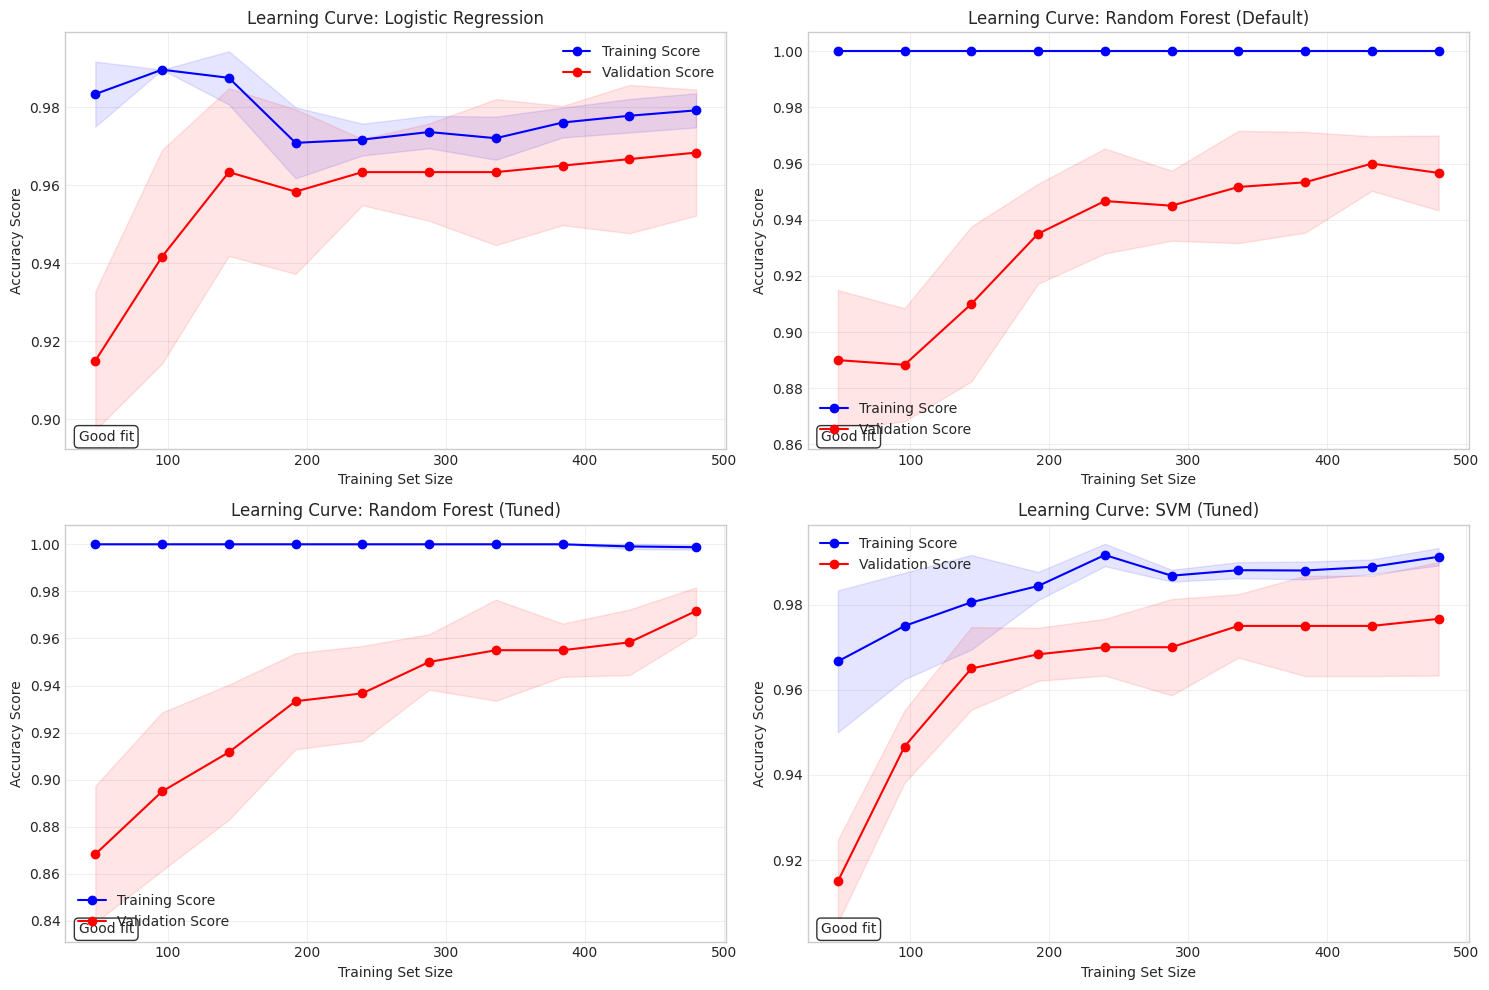

In [ ]:
# Generate learning curves for different models
models_to_compare = {
    'Logistic Regression': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Random Forest (Default)': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    'Random Forest (Tuned)': best_rf,
    'Logistic (Tuned)': best_logit
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (name, model) in enumerate(models_to_compare.items()):
    print(f"Generating learning curve for {name}...")
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', n_jobs=-1
    )
    
    # Calculate means and standard deviations
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot learning curves
    axes[i].plot(train_sizes, train_mean, 'o-', color='blue', 
                label='Training Score')
    axes[i].fill_between(train_sizes, train_mean - train_std,
                        train_mean + train_std, alpha=0.1, color='blue')
    
    axes[i].plot(train_sizes, val_mean, 'o-', color='red', 
                label='Validation Score')
    axes[i].fill_between(train_sizes, val_mean - val_std,
                        val_mean + val_std, alpha=0.1, color='red')
    
    axes[i].set_xlabel('Training Set Size')
    axes[i].set_ylabel('Accuracy Score')
    axes[i].set_title(f'Learning Curve: {name}')
    axes[i].legend()
    axes[i].grid(alpha=0.3)
    
    # Add interpretation text
    final_gap = train_mean[-1] - val_mean[-1]
    if final_gap > 0.1:
        interpretation = "Possible overfitting"
    elif val_mean[-1] < 0.7:
        interpretation = "Possible underfitting"
    else:
        interpretation = "Good fit"
    
    axes[i].text(0.02, 0.02, interpretation, transform=axes[i].transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 6. Model Training Best Practices

Let's summarize the best practices and create a complete model training pipeline.

In [ ]:
def train_and_tune_model(X_train, y_train, model_type='random_forest', 
                        tuning_method='grid', cv_folds=5):
    """
    Complete model training and tuning pipeline.
    
    Parameters:
    -----------
    X_train, y_train : array-like
        Training data and labels
    model_type : str
        Type of model to train ('random_forest', 'svm', 'logistic')
    tuning_method : str
        Hyperparameter tuning method ('grid', 'random', 'none')
    cv_folds : int
        Number of cross-validation folds
    
    Returns:
    --------
    Best trained model and tuning results
    """
    
    # Define base models and parameter grids
    if model_type == 'random_forest':
        base_model = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", RandomForestClassifier(random_state=42))
        ])
        param_grid = {
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [3, 5, 10, None],
            'clf__min_samples_split': [2, 5, 10]
        }
        param_dist = {
            'clf__n_estimators': [50, 100, 150, 200],
            'clf__max_depth': [3, 5, 7, 10, None],
            'clf__min_samples_split': [2, 5, 10, 15]
        }
        
    elif model_type == 'svm':
        base_model = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False)),
            ("clf", SVC(random_state=42, probability=True))
        ])
        param_grid = {
            'clf__C': [0.1, 1, 10, 100],
            'clf__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
            'clf__kernel': ['rbf', 'linear']
        }
        param_dist = {
            'clf__C': loguniform(1e-3, 1e3),
            'clf__gamma': loguniform(1e-4, 1e1),
            'clf__kernel': ['rbf', 'linear']
        }
        
    elif model_type == 'logistic':
        base_model = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False)),
            ("clf", LogisticRegression(random_state=42, max_iter=1000))
        ])
        param_grid = {
            'clf__C': [0.01, 0.1, 1, 10, 100],
            'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear', 'saga']
        }
        param_dist = {
            'clf__C': loguniform(1e-3, 1e3),
            'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear', 'saga']
        }
    
    # Set up cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Perform hyperparameter tuning
    if tuning_method == 'grid':
        print(f"Performing Grid Search for {model_type}...")
        search = GridSearchCV(
            base_model, param_grid, cv=cv,
            scoring='accuracy', n_jobs=-1, verbose=1
        )
    elif tuning_method == 'random':
        print(f"Performing Random Search for {model_type}...")
        search = RandomizedSearchCV(
            base_model, param_dist, n_iter=50, cv=cv,
            scoring='accuracy', n_jobs=-1, verbose=1, random_state=42
        )
    else:  # No tuning
        print(f"Training {model_type} with default parameters...")
        base_model.fit(X_train, y_train)
        return base_model, None
    
    # Fit the search
    start_time = time.time()
    search.fit(X_train, y_train)
    end_time = time.time()
    
    print(f"Tuning completed in {end_time - start_time:.2f} seconds")
    print(f"Best parameters: {search.best_params_}")
    print(f"Best CV score: {search.best_score_:.3f}")
    
    return search.best_estimator_, search

# Example usage
print("Training Random Forest with Grid Search:")
best_model, search_results = train_and_tune_model(
    X_train, y_train, 
    model_type='random_forest', 
    tuning_method='grid'
)

# Evaluate on test set
test_score = best_model.score(X_test, y_test)
print(f"\nFinal test accuracy: {test_score:.3f}")

Training Random Forest with Grid Search:
Performing Grid Search for random_forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuning completed in 9.87 seconds
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.962

Final test accuracy: 0.955
Tuning completed in 9.87 seconds
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.962

Final test accuracy: 0.955


## 7. Final Model Evaluation on Test Set

After all tuning is complete, we evaluate our best model on the held-out test set.


Training Random Forest
Performing Grid Search for random_forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuning completed in 9.66 seconds
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.962
Test accuracy: 0.955

Training SVM
Performing Random Search for svm...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuning completed in 9.66 seconds
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.962
Test accuracy: 0.955

Training SVM
Performing Random Search for svm...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuning completed in 16.85 seconds
Best parameters: {'C': 0.9178539435251554, 'gamma': 0.04108318894699928, 'kernel': 'rbf'}
Best CV score: 0.982
Test accuracy: 0.995

Training Logistic Regression
Performing Grid Search for logistic...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 16.85 seconds
B

/home/chen/miniconda3/envs/gnps/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tuning completed in 1.10 seconds
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.968
Test accuracy: 0.990


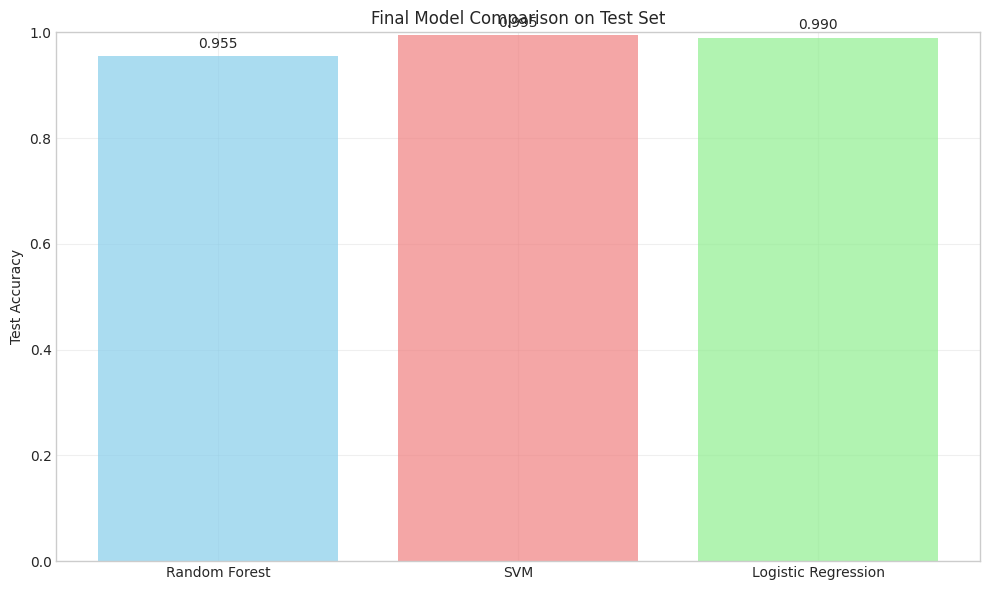


Best performing model: SVM (Test accuracy: 0.995)


In [ ]:
# Train final models and compare
final_models = {}
test_scores = {}

model_configs = [
    ('Random Forest', 'random_forest', 'grid'),
    ('Logistic Regression', 'logistic', 'grid')
]

for name, model_type, tuning_method in model_configs:
    print(f"\n{'='*50}")
    print(f"Training {name}")
    print(f"{'='*50}")
    
    model, search = train_and_tune_model(
        X_train, y_train, 
        model_type=model_type, 
        tuning_method=tuning_method
    )
    
    # Evaluate on test set
    test_score = model.score(X_test, y_test)
    test_scores[name] = test_score
    final_models[name] = model
    
    print(f"Test accuracy: {test_score:.3f}")

# Create final comparison
plt.figure(figsize=(10, 6))
models_names = list(test_scores.keys())
scores = list(test_scores.values())

bars = plt.bar(models_names, scores, alpha=0.7, color=['skyblue', 'lightgreen'])
plt.ylabel('Test Accuracy')
plt.title('Final Model Comparison on Test Set')
plt.ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find the best model
best_model_name = max(test_scores, key=test_scores.get)
print(f"\nBest performing model: {best_model_name} (Test accuracy: {test_scores[best_model_name]:.3f})")

## Summary

In this notebook, we covered the essential aspects of model training for machine learning in metabolomics:

### Key Concepts Learned:

1. **Model Complexity Trade-offs**: Understanding the balance between simple and complex models
2. **Hyperparameter Tuning**: Using Grid Search and Random Search to optimize model performance
3. **Cross-Validation**: Implementing robust evaluation strategies, especially important for smaller datasets
4. **Learning Curves**: Diagnosing overfitting and underfitting issues
5. **Best Practices**: Creating reproducible training pipelines

### Practical Guidelines:

- **Start simple**: Begin with simple models (Logistic Regression) before moving to complex ones
- **Use proper validation**: Always use cross-validation for model selection
- **Tune systematically**: Grid Search for smaller parameter spaces, Random Search for larger ones
- **Monitor overfitting**: Use learning curves to understand model behavior
- **Save computation**: Use n_jobs=-1 for parallel processing when possible

### Next Steps:

In the next notebook, we'll focus on model evaluation, learning how to:
- Calculate and interpret various performance metrics
- Identify and address overfitting issues
- Compare models against established benchmarks
- Create comprehensive evaluation reports

The trained models from this notebook will serve as the foundation for our evaluation studies.